Cette partie est une application du début du livre de Christopher M.Bishop "Pattern Recognition and Machine Learning  dans laquelle j'essaie de mettre en pratique ce que j'ai lu. 

En commmencant par du curve fitting sur les données météorologiques à une heure donnée à un lieu donné. Cependant contrairement à précedement, il nous faut utiliser au moins deux années distinctes pour un même endroit pour bien capter la presque-périodicité des données. Sinon un polynome de degré 2 approche très très bien les données sur une année, mais ne permettrait pas de comprende les tendances entre années 

I) Polynomial Curve Fitting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from scipy.optimize import minimize
from scipy.optimize import curve_fit

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [3]:
#ouverture des fichiers pour l'instant pas toutes les communes car très long à obtenir mais un jour peut-être !
communes_de_france_part1_predicted = pd.read_csv('france_communes_hourly_past_predicted_temperature_2m_2023_partie1.csv')
communes_de_france_part1_real = pd.read_csv('france_communes_hourly_past_real_temperature_2m_2023_partie1.csv')

In [4]:
#on renomme la colonne température du fichier des relevés pour distinguer températures réelles des températures prédites 
communes_de_france_part1_real = communes_de_france_part1_real.rename(columns={'temperature_2m': 'temperature_relle_2m'})

In [5]:
# on joint les deux fichier pour pouvoir comparer au sein d'une mêm table les températures à une même date et un même lieu
merged_df = pd.merge(communes_de_france_part1_real,communes_de_france_part1_predicted, on=['date', 'longitude', 'latitude'])
print(len(merged_df))
print(merged_df)

21826215
          Unnamed: 0_x                       date  temperature_relle_2m  \
0                    0  2023-01-01 00:00:00+00:00             13.233999   
1                    1  2023-01-01 01:00:00+00:00             12.983999   
2                    2  2023-01-01 02:00:00+00:00             12.684000   
3                    3  2023-01-01 03:00:00+00:00             12.283999   
4                    4  2023-01-01 04:00:00+00:00             12.134000   
...                ...                        ...                   ...   
21826210          8755  2023-12-31 19:00:00+00:00              9.184000   
21826211          8756  2023-12-31 20:00:00+00:00              8.384000   
21826212          8757  2023-12-31 21:00:00+00:00              8.684000   
21826213          8758  2023-12-31 22:00:00+00:00              9.084001   
21826214          8759  2023-12-31 23:00:00+00:00              8.434000   

           latitude  longitude  Unnamed: 0_y  temperature_2m  
0         46.153426   4.926

In [6]:
#ajout des colonnes erreur et erreur absolue. Cette dernière est importante car le modèle se trompe presque autant en positif qu'en négatif, ainsi la moyenne de l'erreur est presque nuelle, ce qui ne nous renseigne pas beaucoup 

merged_df["error"]=merged_df["temperature_2m"]-merged_df["temperature_relle_2m"]
merged_df["absolute_error"]=abs(merged_df["error"])

In [7]:
merged_df['date'] = pd.to_datetime(merged_df['date']) # pour pouvoir facilement selectionner la date 

In [8]:
fin_apres_midi = merged_df[merged_df["date"].dt.hour == 18]
un_lieu_une_heure = fin_apres_midi.head(365)
un_lieu_une_heure.describe()



,Unnamed: 0_x,temperature_relle_2m,latitude,longitude,Unnamed: 0_y,temperature_2m,error,absolute_error
count,365.000000,365.000000,3.650000e+02,3.650000e+02,365.000000,365.000000,365.000000,365.000000
mean,4386.000000,14.589890,4.615343e+01,4.926114e+00,4386.000000,14.757572,0.167682,1.056455
std,2532.255911,8.631017,7.115181e-15,8.893976e-16,2532.255911,8.537442,1.452150,1.008846
min,18.000000,-2.066000,4.615343e+01,4.926114e+00,18.000000,-1.624000,-5.508000,0.007999
25%,2202.000000,7.734000,4.615343e+01,4.926114e+00,2202.000000,7.876000,-0.508002,0.342000
50%,4386.000000,14.033999,4.615343e+01,4.926114e+00,4386.000000,14.276000,0.142000,0.758000
75%,6570.000000,21.934000,4.615343e+01,4.926114e+00,6570.000000,21.726000,0.992001,1.457999
max,8754.000000,32.534000,4.615343e+01,4.926114e+00,8754.000000,33.676003,6.841998,6.841998


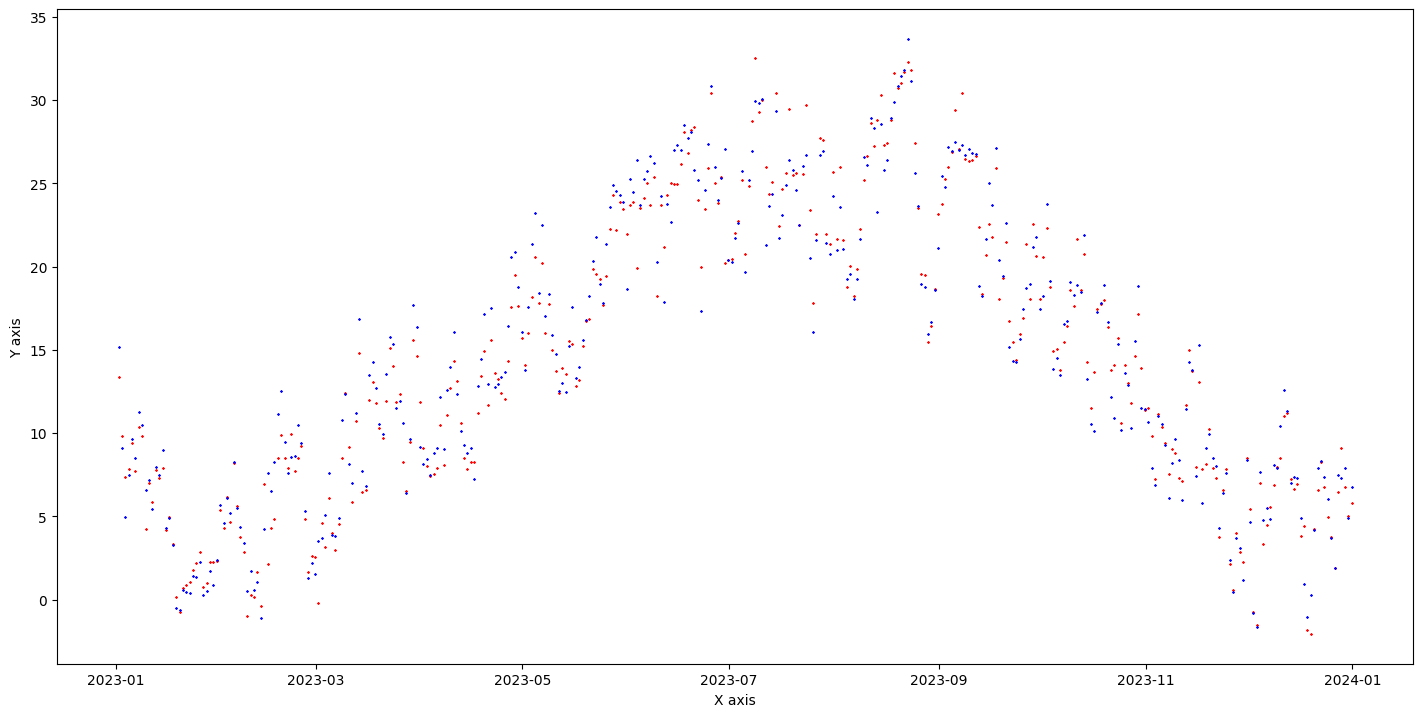

In [10]:
x = un_lieu_une_heure["date"]
y1 = un_lieu_une_heure["temperature_relle_2m"]
y2 = un_lieu_une_heure["temperature_2m"]

fig = plt.figure(figsize=(17.5,8.5))

# Scatter plot the points
plt.scatter(x, y1, c='r', marker='X', s=0.5) # température réelle 
plt.scatter(x, y2, c='b', marker='X', s=0.5)  # température prédite par le modèle 

# Set labels
plt.xlabel('X axis')
plt.ylabel('Y axis')


plt.show()

Tentative de curve fitting en codant soit même la fonction polynomiale et la fonction d'erreur (erreur quadratique), en utilisant scipy et minimize pour obtenir les coefficients du polynome minimisant l'erreur 

In [12]:
M=3 #degré du polynome

X=un_lieu_une_heure["temperature_2m"].sample(10).head(10)
T=un_lieu_une_heure["temperature_relle_2m"].head(10)

print(X)
def y(x, w): 
    somme=0
    for i in range(M):
        print(i)
        coeff = w[i]*x**i
        somme+=coeff
    return somme 

def error_function(w):
    error=0
    for i in range(len(X)):
        coeff=(y(X[i],w)-T[i])**2
        error+=coeff
    return(1/2 * error)


x0 = np.array([-1,2,-3,10])
result = minimize(error_function, x0)
argmin = result.x
print("Argmin:", argmin)


polynome = np.polynomial.Polynomial(argmin)
x = np.linspace(-10, 10, 1000)
y_value = y(x, argmin) 

plt.plot(x, y_value)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial Function Plot')
plt.grid(True)
plt.show()


4866    26.026000
3330    16.776000
6810    18.925999
546      1.426000
1074     7.576000
1722    16.876000
8490     4.176000
8538     8.326000
2634    12.926000
7866     7.626000
Name: temperature_2m, dtype: float64


KeyError: 0

Utilisation de la fonction curve_fit de scipy :

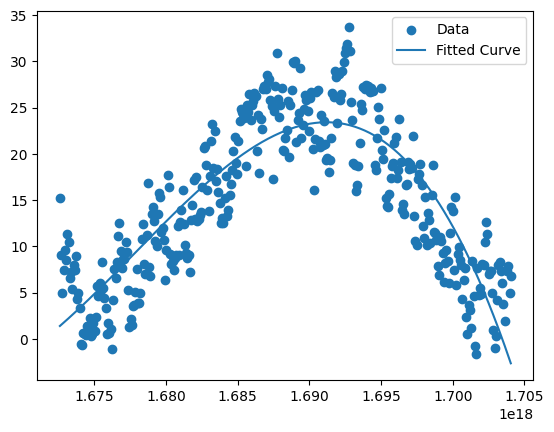

In [14]:
time = un_lieu_une_heure["date"].values.astype(float)
real_values = un_lieu_une_heure["temperature_relle_2m"].values
values=un_lieu_une_heure["temperature_2m"].values

def polynomial(x, a, b, c, d):
    return a * x**4 + b * x**3 + c*x**2 + d*x 


# Fit the curve
popt, pcov = curve_fit(polynomial, time, values )

# Plot the data and the fitted curve

plt.scatter(time, values, label='Data')
plt.plot(time, polynomial(time, *popt), label='Fitted Curve')
plt.legend()
plt.show()

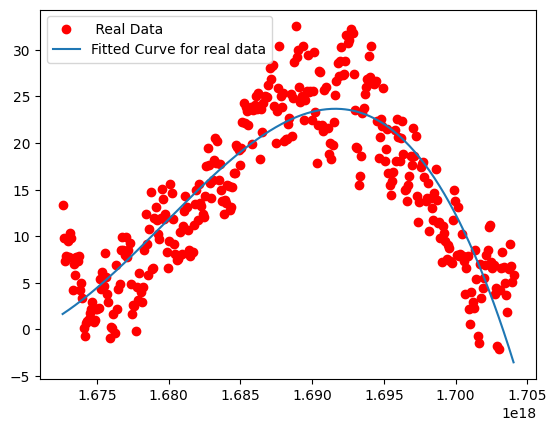

In [15]:
time = un_lieu_une_heure["date"].values.astype(float)
real_values = un_lieu_une_heure["temperature_relle_2m"].values

def polynomial(x, a, b, c, d):
    return a * x**4 + b * x**3 + c*x**2 + d*x 

# Fit the curve
popt, pcov = curve_fit(polynomial, time, real_values )

# Plot the data and the fitted curve

plt.scatter(time, real_values, label=' Real Data' , c="r")
plt.plot(time, polynomial(time, *popt), label='Fitted Curve for real data')
plt.legend()
plt.show()


Comparaison des fonctions polynomiales approchant les données prédites (en marron) et réelle (en bleu)

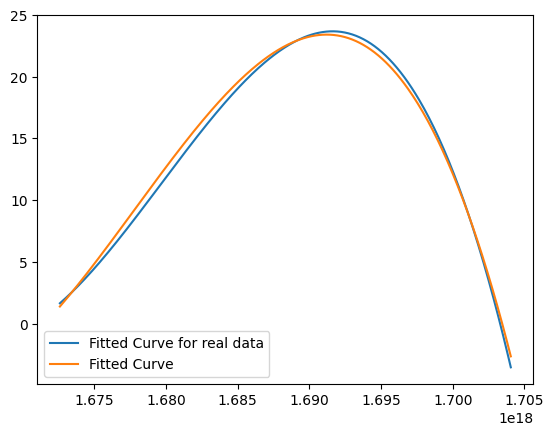

In [16]:
popt1, pcov1 = curve_fit(polynomial, time, real_values )
popt, pcov = curve_fit(polynomial, time, values )

plt.plot(time, polynomial(time, *popt1), label='Fitted Curve for real data')
plt.plot(time, polynomial(time, *popt), label='Fitted Curve')
plt.legend()
plt.show()